# When to learn? 

Keeping track of environmental modifications is an important asset to survive and to properly perform spatial navigation for both animals and robots. Despite the extensive research on the role of the mammalian hippocampus in encoding and represent the animals spatial location, how the hippocampus detects novelty is still unclear. Hippocampal models for spatial encoding are often trained and tested within static environments, whereas in the real world the explored environments are in constant modifications. Here, we present a simple, yet generalizable model of novelty detection encapsulated within hippocampal populations of entorhinal (EC) grid- and sensory-cells. The model relies on a sequential autoencoder architecture and learns to reproduce population vector activity from lateral and medial EC cells. Further, we discuss possible scenarios where this model could be used for novelty detection and trigger learning, and suggest a possible hippocampal circuitry capable of novelty detection.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from HPC_lib import *

Using TensorFlow backend.


# Build training data structure

<li> Each input vector represents the population vector activity of MEC and LEC cells at a given location.
<li> Half the vector contains MEC cells, the other half LEC cells.
<li> For the data-structure we will set a population of MEC cells and 2 populations of LEC cells (LEC_1 and LEC_2)
<li> We will train an autoencoder to classify the input vector (MEC + LEC_1).
<li> After training, we will test the accuracy error by progressively changing from LEC_1 context to LEC_2 context. (a la rate-remapping morphing Leutgeb)

In [2]:
# Make data structure combining both MEC and LEC_1
n_mec = 30
n_lec = 70
arena_size=[100,100]
arena = Arena(arena_size=arena_size, n_mec=n_mec, n_lec=n_lec)
data = arena.get_rateMaps()

# Illustrations

MEC maps


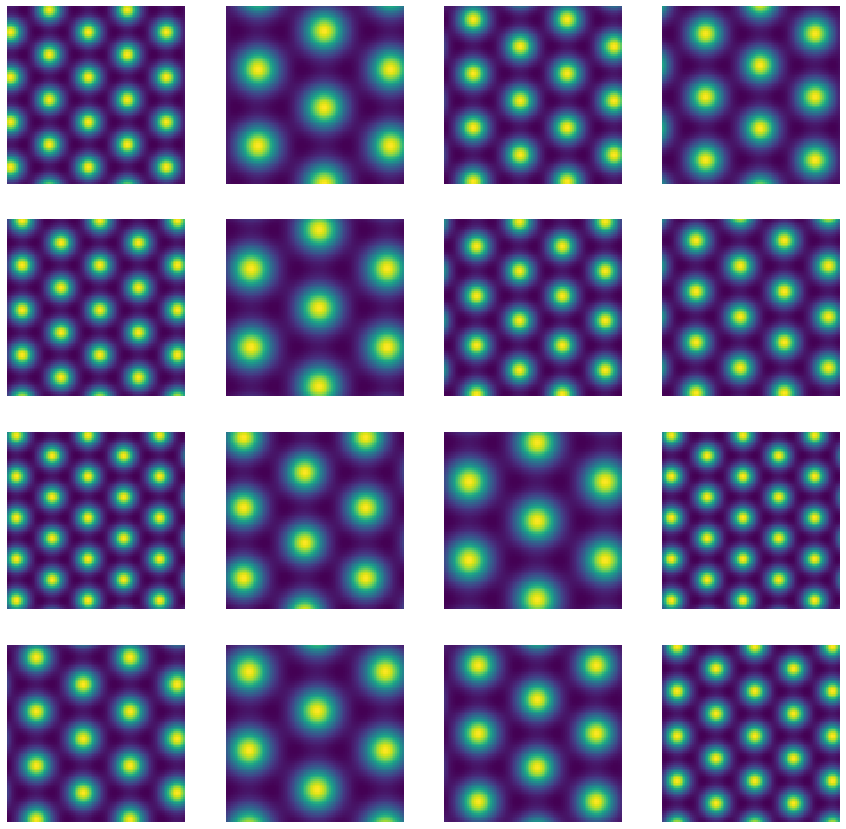


LEC maps


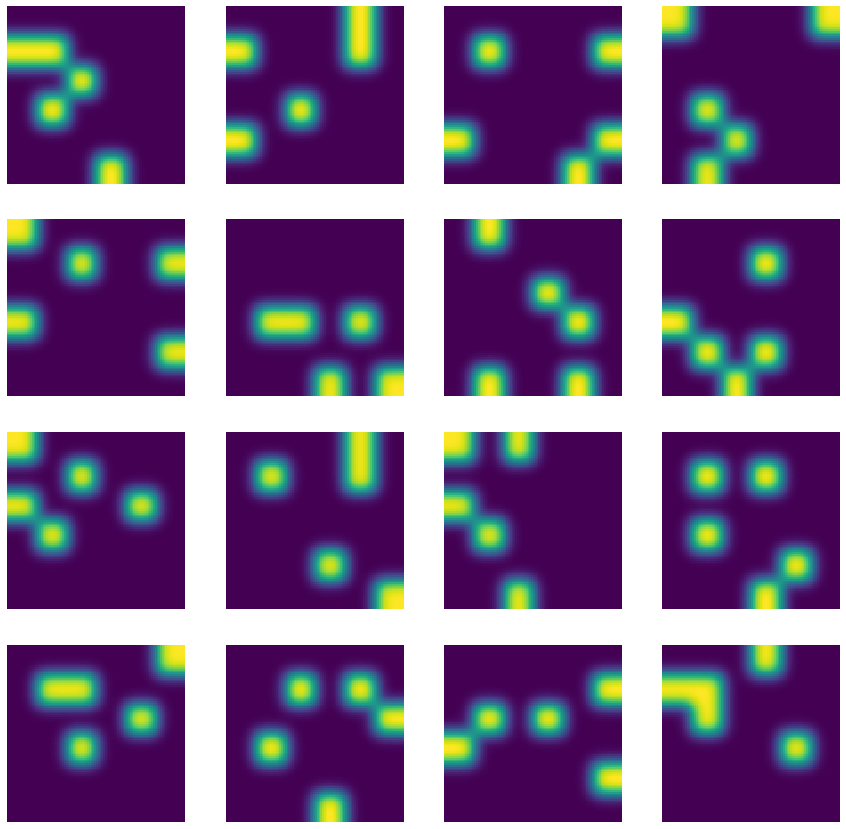

In [3]:
arena.plot_rateMaps()

# Autoencoder model

In [4]:
## Define parameters of the model.
n_DG, n_CA3, n_CA1 = [1000, 200, 300] 

model = HPC(n_DG=n_DG, n_CA3=n_CA3, n_CA1=n_CA1, dim=n_mec+n_lec)
history = model.train(data=data, epochs=100)

W1106 14:32:07.309666  7832 deprecation_wrapper.py:119] From C:\Users\adria\Miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1106 14:32:07.329237  7832 deprecation_wrapper.py:119] From C:\Users\adria\Miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1106 14:32:07.330266  7832 deprecation_wrapper.py:119] From C:\Users\adria\Miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1106 14:32:07.464364  7832 deprecation_wrapper.py:119] From C:\Users\adria\Miniconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DG (Dense)                   (None, 1000)              101000    
_________________________________________________________________
CA3 (Dense)                  (None, 200)               200200    
_________________________________________________________________
CA1 (Dense)                  (None, 300)               60300     
_________________________________________________________________
EC (Dense)                   (None, 100)               30100     
Total params: 391,600
Trainable params: 391,600
Non-trainable params: 0
_________________________________________________________________


W1106 14:32:07.723993  7832 deprecation_wrapper.py:119] From C:\Users\adria\Miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W1106 14:32:07.985460  7832 deprecation_wrapper.py:119] From C:\Users\adria\Miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



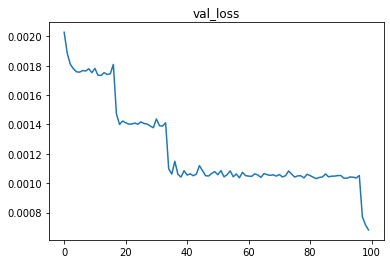

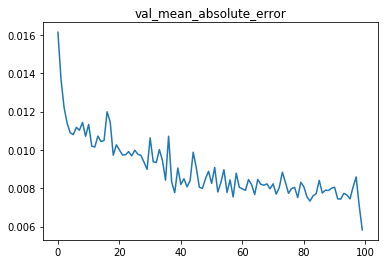

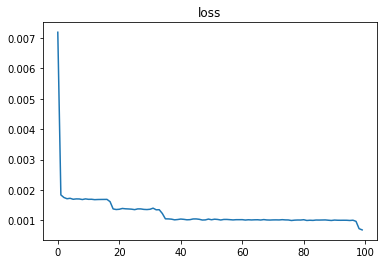

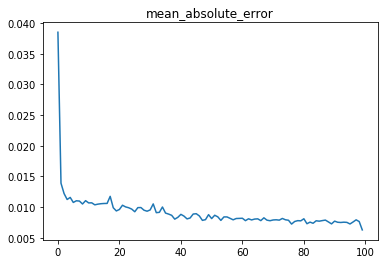

In [5]:
for kk in history.history.keys():
    plt.plot(history.epoch, history.history[kk])
    plt.title(kk)
    plt.show()

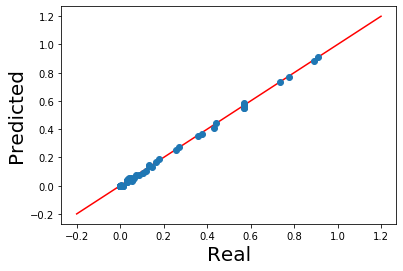

MSE:  0.06730149287805658


In [6]:
pos_n = 10

pred = model.test(np.array([data[pos_n]])).T

plt.plot( [-.2,1.2], [-.2,1.2], 'r' )
plt.plot( data[pos_n], pred , 'o' )

plt.xlabel('Real', fontsize=20)
plt.ylabel('Predicted', fontsize=20)
plt.show()

print ( 'MSE: ' , np.sqrt(np.sum(np.power(data[pos_n] - pred[:,0], 2))) )

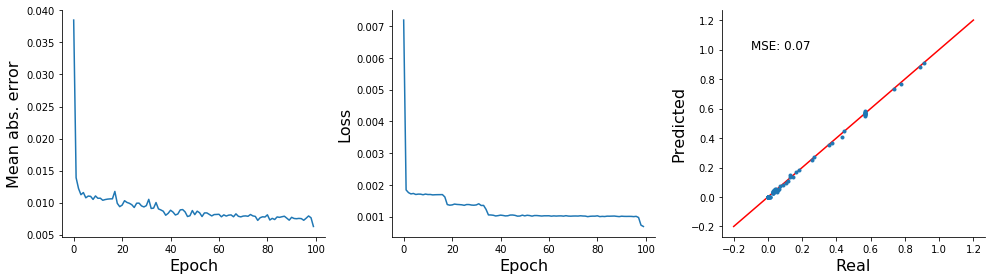

In [7]:
fig, ax = plt.subplots(1,3)
fig.set_figheight(4)
fig.set_figwidth(14)
fig.set_facecolor('white')


ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
plt.sca(ax[0])
    
plt.plot(  history.epoch, history.history['mean_absolute_error'] )
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Mean abs. error', fontsize=16)


ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
plt.sca(ax[1])

plt.plot( history.epoch, history.history['loss'] )
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)


ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)
plt.sca(ax[2])

pos_n = 10
pred = model.test(np.array([data[pos_n]])).T
tt = 'MSE: ' + str( np.round(np.sqrt(np.sum(np.power(data[pos_n] - pred[:,0], 2) )),2) )

plt.plot( [-.2,1.2],[-.2,1.2],'r'  )
plt.plot( data[pos_n], pred , 'o', markersize=3)
plt.text(-.1,1,tt, fontsize=12)
plt.xlabel('Real', fontsize=16)
plt.ylabel('Predicted', fontsize=16)

plt.tight_layout()
plt.show()

In [8]:
error_log = []
for pos_n in range(data.shape[0]):

    pred = model.test(np.array([data[pos_n]])).T

    error_log.append(np.sqrt(np.sum(np.power(data[pos_n] - pred[:,0], 2))))

# Test Error by including LEC_2 cells

In [9]:
error_log_total_mean = []
error_log_total_std = []
error_log_total_sem = []

for dd in np.linspace(0,1,11):

    new_data = arena.modify_LEC_maps(dd, permanent=False)

    error_log = []
    for pos_n in range(4000):

        pred = model.test(np.array([new_data[pos_n]])).T
        error_log.append(np.sqrt(np.sum(np.power(new_data[pos_n] - pred[:,0], 2))))

    error_log_total_mean.append(np.mean(error_log))
    error_log_total_std.append(np.std(error_log))
    error_log_total_sem.append(stats.sem(error_log))

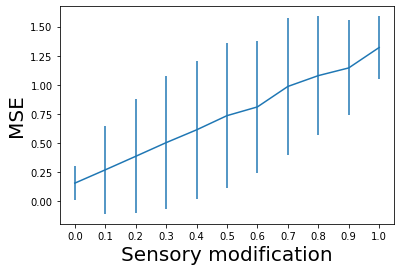

In [10]:
plt.errorbar(range(len(error_log_total_mean)), error_log_total_mean, yerr=error_log_total_std)

plt.xticks(range(11), np.round(np.linspace(0,1,11),2) )

plt.ylabel("MSE", fontsize=20)
plt.xlabel("Sensory modification", fontsize=20)
plt.show()

# As if it was during navigation

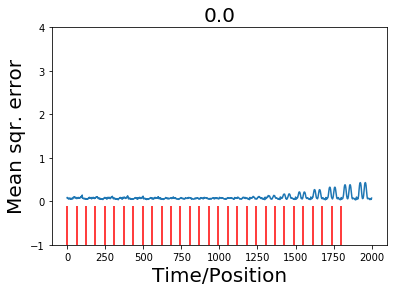

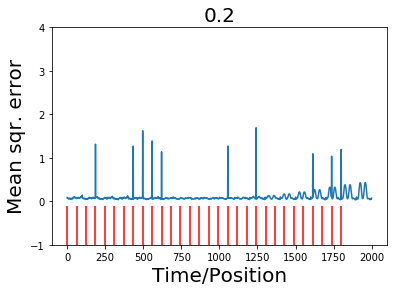

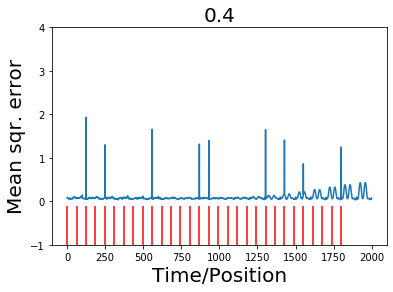

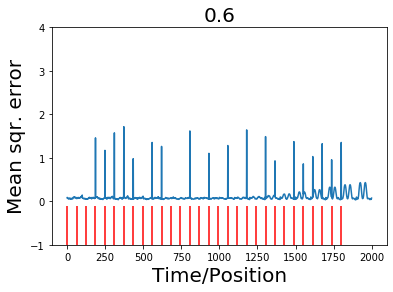

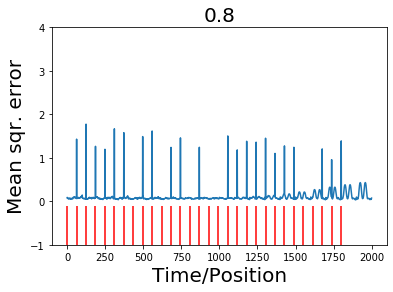

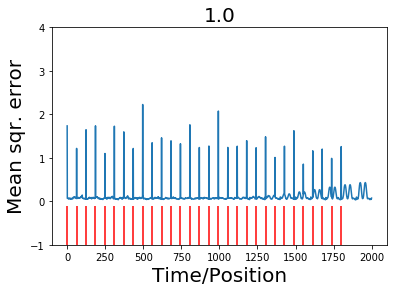

In [11]:
modification_times = np.linspace(0, 1800, 30).astype(int)

detected_modification = []
for dd in np.linspace(0,1,6):
    
    new_data = arena.modify_LEC_maps(dd, permanent=False)
    error_log = []
    for pos_n in range(2000):

        if pos_n in modification_times:
            pred = model.test(np.array([new_data[pos_n]])).T
            error_log.append(np.sqrt(np.sum(np.power(new_data[pos_n] - pred[:,0], 2) )))

        else:
            pred = model.test(np.array([data[pos_n]])).T
            error_log.append(np.sqrt(np.sum(np.power(data[pos_n] - pred[:,0], 2) )))

    error_log = np.array(error_log)    
    detected_modification.append(np.where(error_log>0.5)[0].size / error_log.size)

    plt.plot(error_log)
    plt.vlines(modification_times, -1,-.1,'r')
    plt.title(np.round(dd,2), fontsize=20)
    plt.ylabel("Mean sqr. error", fontsize=20)
    plt.xlabel("Time/Position", fontsize=20)
    plt.ylim(-1,4)    
    plt.show()

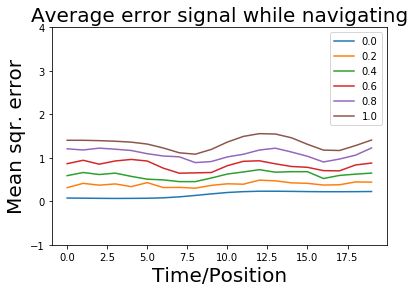

In [12]:
detected_modification = []
for dd in np.linspace(0,1,6):
    
    new_data = arena.modify_LEC_maps(dd, permanent=False)
    error_log = []
    for pos_n in range(4000):

        pred = model.test(np.array([new_data[pos_n]])).T
        error_log.append(np.sqrt(np.sum(np.power(new_data[pos_n] - pred[:,0], 2) )))

    error_log = np.array(error_log)    
    detected_modification.append(np.where(error_log>1)[0].size / error_log.size)
    
    error_log = np.mean(error_log.reshape((int(error_log.size/200),200)), axis=1)
    plt.plot(error_log, label=str(np.round(dd,2)))
    
plt.title('Average error signal while navigating', fontsize=20)
plt.ylabel("Mean sqr. error", fontsize=20)
plt.xlabel("Time/Position", fontsize=20)
plt.ylim(-1,4)    
plt.legend()
plt.show()

In [13]:
modification_times = np.linspace(0, 1800, 30).astype(int)

detected_modification_mean = []
detected_modification_std = []
detected_modification_sem = []

for dd in np.linspace(0,1,11):

    tmp_detected_modification = []
    
    for ii in range(20):

        new_data = arena.modify_LEC_maps(dd, permanent=False)

        error_log = []
        for pos_n in range(2000):

            if pos_n in modification_times:

                pred = model.test(np.array([new_data[pos_n]])).T
                error_log.append(np.sqrt(np.sum(np.power(new_data[pos_n] - pred[:,0], 2) )))

            else:
                pred = model.test(np.array([data[pos_n]])).T
                error_log.append(np.sqrt(np.sum(np.power(data[pos_n] - pred[:,0], 2) )))

        error_log = np.array(error_log)    
        tmp_detected_modification.append( np.where(error_log>0.5)[0].size / float(modification_times.size) )
        
    detected_modification_mean.append(  np.mean(np.array(tmp_detected_modification)) )
    detected_modification_std.append(  np.mean(np.array(tmp_detected_modification)) )
    detected_modification_sem.append(  stats.sem(np.array(tmp_detected_modification)) )

Text(0.5, 0, 'Sensory modification')

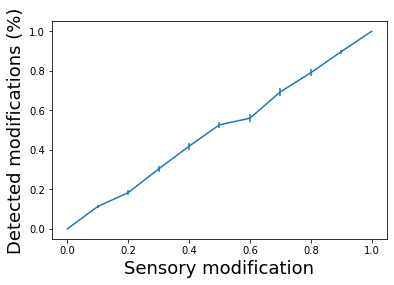

In [14]:
plt.errorbar(  np.linspace(0,1,11), np.array(detected_modification_mean), yerr=detected_modification_sem)

# plt.xticks(range(11), np.round(np.linspace(0,1,11),2) )

plt.ylabel("Detected modifications (%)", fontsize=18)
plt.xlabel("Sensory modification", fontsize=18)

# plt.plot([0,1],[0,1])

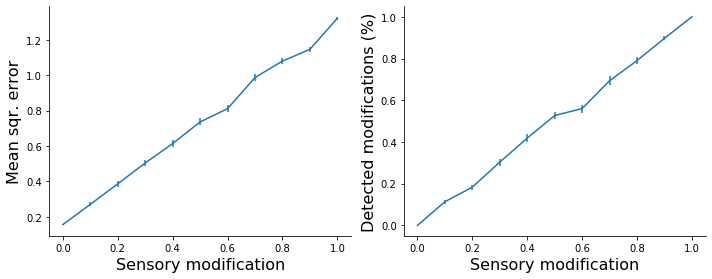

In [15]:
fig , ax = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(10)
fig.set_facecolor('white')



ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
plt.sca(ax[0])
plt.errorbar(  range(len(error_log_total_mean)), error_log_total_mean, yerr=np.array(error_log_total_sem)*2)
plt.xticks(np.linspace(0,10,6), np.round(np.linspace(0,1,6),2) )
plt.ylabel("Mean sqr. error", fontsize=16)
plt.xlabel("Sensory modification", fontsize=16)




ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
plt.sca(ax[1])
plt.errorbar(  np.linspace(0,1,11), np.array(detected_modification_mean), yerr=detected_modification_sem)
plt.ylabel("Detected modifications (%)", fontsize=16)
plt.xlabel("Sensory modification", fontsize=16)



plt.tight_layout()


#plt.savefig('./figures/model_error_and_detection.pdf')

In [16]:
modification_times = np.linspace(0, 1800, 30).astype(int)
error_log_all_for_plot = []

for dd in np.linspace(0,1,6):
    
    new_data = arena.modify_LEC_maps(dd, permanent=False)
    error_log = []
    for pos_n in range(2000):

        if pos_n in modification_times:
            pred = model.test(np.array([new_data[pos_n]])).T
            error_log.append(np.sqrt(np.sum(np.power(new_data[pos_n] - pred[:,0], 2) )))

        else:
            pred = model.test(np.array([data[pos_n]])).T
            error_log.append(np.sqrt(np.sum(np.power(data[pos_n] - pred[:,0], 2) )))

    error_log = np.array(error_log)    
    error_log_all_for_plot.append(error_log)

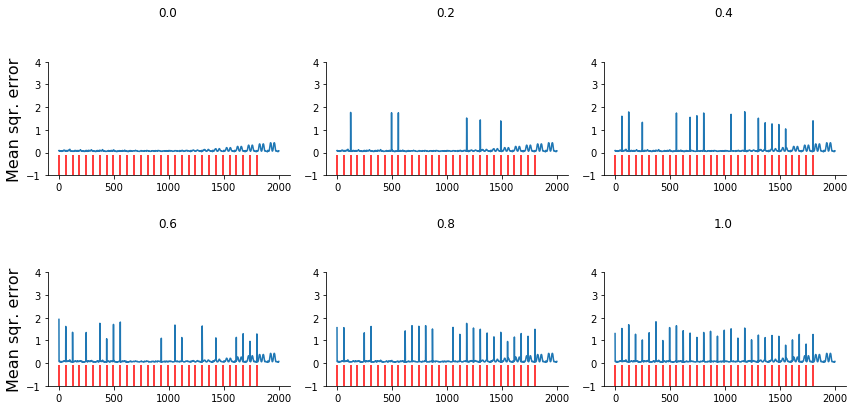

In [17]:
fig , ax = plt.subplots(2,3)
fig.set_figheight(6)
fig.set_figwidth(12)
fig.set_facecolor('white')


for ii in range(len(error_log_all_for_plot)):
    
    ax[int(ii/3), int(ii%3)].spines['right'].set_visible(False)
    ax[int(ii/3), int(ii%3)].spines['top'].set_visible(False)
    plt.sca(ax[int(ii/3), int(ii%3)])

    plt.plot(error_log_all_for_plot[ii])
    plt.vlines(modification_times, -1,-.1,'r')
    
    tt = str(np.round(np.linspace(0,1,6)[ii],2))
    plt.text(900,6,tt, fontsize=12)
    
    if ii%3 == 0: plt.ylabel("Mean sqr. error", fontsize=16)
    if ii/3 == 1 and ii%3 == 1: plt.xlabel("Time/Position", fontsize=16)
    plt.ylim(-1,4)
    
    
plt.tight_layout()    
#plt.savefig('./figures/detections.pdf')

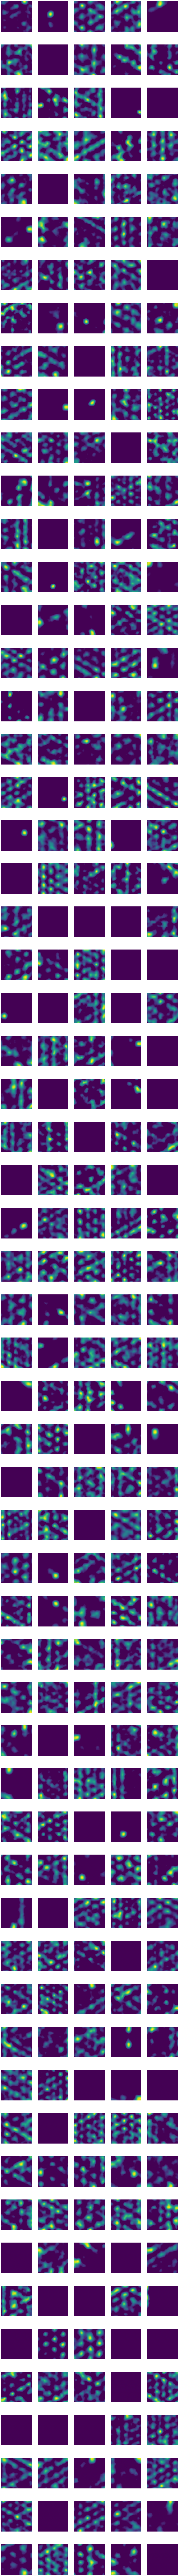

In [18]:
## COMPUTE THE ACTIVATION HEATMAPS FOR A MIDDLE LAYER WHILE NAVIGATING THROUGH THE WHOLE ARENA ###################

heatmaps = np.zeros((n_CA1,arena_size[0], arena_size[1]))                  # activations from neurons in SoftMax layer for the whole 50x50 arena
layer = 'CA1'

for pos in range(data.shape[0]):                  # go through the whole arena
    out = model.get_output(layer=layer, data=np.array([data[pos]]))       # activate network and get SoftMax outputs
    heatmaps[:, int(pos/arena_size[0]), int(pos%arena_size[1])] += out.ravel()    # save the outputs

    
maxx, minn = 0, 10
for i in range(n_CA1):
    if np.max(heatmaps[i]) > maxx: maxx = np.max(heatmaps[i])
    if np.min(heatmaps[i]) < minn: minn = np.min(heatmaps[i])

fig = plt.figure(figsize=(16, 4*n_CA1/5))  

for i in range(n_CA1):
    plt.subplot(n_CA1/5, 5, i+1)
    plt.imshow(heatmaps[i])    
    plt.axis('off')

# Quantify place fields

In [ ]:
def get_number_of_place_fields(ratemap):
    
    gauss_kernel_sigma      = 9  # px
    active_pixels_threshold = .2 # 20 percent
    cluster_min             = 200/2
    cluster_max             = 2500/2
    
    ratemap[ ratemap <  ratemap.max()*active_pixels_threshold ] = 0
    ratemap[ ratemap >= ratemap.max()*active_pixels_threshold ] = 1


    visited_matrix  = np.zeros_like(ratemap)


    ratemap[ ratemap <  ratemap.max()*active_pixels_threshold ] = 0
    ratemap[ ratemap >= ratemap.max()*active_pixels_threshold ] = 1

    visited_matrix  = np.zeros_like(ratemap)




    ## First pass of clustering
    clusterd_matrix = np.zeros_like(ratemap)
    current_cluster = 1

    #go through every bin in the ratemap
    for yy in range(1,ratemap.shape[0]-1):
        for xx in range(1,ratemap.shape[1]-1):

            if ratemap[  yy, xx ] == 1:

                ## go through every bin around this bin
                for ty in range(-1,2):
                    for tx in range(-1,2):

                        if clusterd_matrix[ yy+ty, xx+tx ] != 0:
                            clusterd_matrix[ yy,xx ] = clusterd_matrix[ yy+ty, xx+tx ]

                if clusterd_matrix[ yy, xx ] == 0:
                    current_cluster += 1
                    clusterd_matrix[ yy, xx ] = current_cluster



    ## Refine clustering: neighbour bins to same cluster number
    for yy in range(1,clusterd_matrix.shape[0]-1):
        for xx in range(1,clusterd_matrix.shape[1]-1):


            if clusterd_matrix[  yy, xx ] != 0:

                ## go through every bin around this bin
                for ty in range(-1,2):
                    for tx in range(-1,2):

                        if clusterd_matrix[ yy+ty, xx+tx ] != 0:
                            if clusterd_matrix[ yy+ty, xx+tx ] != clusterd_matrix[  yy, xx ]:
                                clusterd_matrix[ yy+ty, xx+tx ] = clusterd_matrix[  yy, xx ]







    ## Quantify number of place fields
    clusters_labels = np.delete(np.unique(clusterd_matrix),   np.where(  np.unique(clusterd_matrix) ==0 ) )

    n_place_fields_counter = 0

    for k in range(clusters_labels.size):

        n_bins = np.where(clusterd_matrix == clusters_labels[k] )[0].size

        if cluster_min <= n_bins <= cluster_max:

            n_place_fields_counter += 1

            
            
    return n_place_fields_counter

In [ ]:
# layer_name = ['dense','dense_1','dense_2', 'softmax','dense_3', 'softmax_1','dense_4']
# layer_size = [200,100,100,100,50,50,200]

place_field_number = []

log_layer_name = []  ## save the layers name for plotting

for layer_n in range( len(model.get_config()['layers']) ):

    tmp_place_field_number = []
    
    ## COMPUTE THE ACTIVATION HEATMAPS FOR SOFTMAX LAYER WHILE NAVIGATING THROUGH THE WHOLE ARENA ###################

    
    layer_name = model.get_config()['layers'][layer_n]['config']['name']
    log_layer_name.append(layer_name)
    try: ## unfortunately 'softmax' layers have no units object. So just pick the previous one :/
        units      = model.get_config()['layers'][layer_n]['config']['units']
    except: pass

    
    heatmaps = np.zeros((units,50,50))      # activations from neurons in SoftMax layer for the whole 50x50 arena

    m2 = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)  # the way to get a layer's output in Keras

    for pos in range(data.shape[0]):                  # go through the whole arena

        out = m2.predict(np.array([data[pos]]))       # activate network and get SoftMax outputs
        heatmaps[:, pos/50, pos%50] += out.ravel()    # save the outputs

        
    for cell in range(heatmaps.shape[0]):
        
        tmp_place_field_number.append(get_number_of_place_fields(heatmaps[cell]))
        
        
    place_field_number.append(tmp_place_field_number)
        

In [ ]:
hist_min, hist_max = 100,10
for ii in range(1,4):#  len(place_field_number)):

    tmp_min = np.min(np.histogram(place_field_number[ii])[0])
    tmp_max = np.max(np.histogram(place_field_number[ii])[0])
    
    if tmp_min<hist_min: hist_min=tmp_min
    if tmp_max>hist_max: hist_max=tmp_max
    


plt.figure(figsize=(5,20))

for ii in range(len(place_field_number)):
    
    
    nn_place = []
    for ccc in range(0,9):
        nn_place.append( np.where(np.array(place_field_number[ii]) == ccc)[0].size  )
        
    nn_place = np.array(nn_place).astype(float)    
    nn_place = nn_place / nn_place.sum()

    plt.subplot(len(place_field_number),1,ii+1)
#     plt.hist(place_field_number[ii])
    plt.bar(  range(len(nn_place))  , nn_place )
    plt.title(log_layer_name[ii])
    plt.xlim(-1,8)
    
#     plt.ylim(0, hist_max+10)